Los objetivos de este notebook son:
- Ilustrar la extracción de un diccionario de tokens de un texto.
- Ilustrar el proceso de tokenización de una secuencia de palabras
- Aplicar procesos de padding y truncating en la tokenización de secuencias de texto
- Crear un modelo de clasificación de texto (análisis de sentimiento) usando capas recurrentes, y capas recurrentes bidireccionales.
- Utilizar embeddings para representar secuencias de tokens categóricos en un espacio vectorial multidimensional
- Realizar transfer learning de embeddings preentrenados.
- Utilizar las funcionalidades de base del package `torchtext`.

Este notebook está basado en material encontrado en:
- *Machine Learning with PyTorch and Scikit-Learn*, Sebastian Raschka, Yuxi Liu & Vahid Mirjalili, Packt, 2022
- *Dive into Deep Learning*, Aston Zhang, Zachary C. Lipton, Mu Li & Alexander J. Smola, https://d2l.ai/, 2022
- *Deep Learning Specialization*, DeepLearning.AI, (acceso nov 2020), Coursera
- *PyTorch*, https://pytorch.org/

In [1]:
import re
import os
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter, OrderedDict

Vamos a utilizar la libreria `torchtext` de tratamiento de texto y a requerir `torchdata` para acceder a datasets de ejemplo.

In [2]:
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
import torch
import torch.nn as nn
from torchtext.vocab import vocab
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

Para poder analizar y procesar secuencias de términos es necesario primero definir el tipo de representación que se va a utilizar, y los procesos de pre procesamiento que las normalizarán. 

En el caso de texto, los elementos de las secuencias tienen una representación categórica, por lo que hay que pre-procesarlos con el objetivo de encontrar una **representación numérica**. Esto se logra con en 2 pasos:
- Primero, es necesario identificar la unidad atómica de tratamiento, ya sea palabras, caracteres, o subpalabras. A este proceso se le llama **tokenización**, y consiste en definir el vocabulario que se va a tomar como punto de partida del análisis, identificando los términos únicos a considerar.
- Luego hay que codificar los tokens numéricamente para que puedan ser procesados por modelos de redes neuronales; que una palabra no sea un ID categórico sin orden determinado (token), sino un punto en un espacio multidimensional. A este proceso se le llama **vectorización**, y hay dos aproximaciones para esta tarea:
    - **One hot encoding**: se utiliza un espacio de representación donde cada dimensión corresponde a uno de los posibles términos que se pueden encontrar en las secuencias. Cada término en una secuencia es entonces representado como un vector de muchísimos 0s, salvo por la dimensión que corresponde al término en sí. Esto crea problemas, pues este espacio es bastante disperso (muy pocos 1s), de muy alta dimensionalidad, y codificado "en duro" (la posición de cada término sigue un proceso arbitrario no basado en los datos en sí)
    - **Embedding**: se utiliza un espacio de representación de dimensionalidad reducida, cuyo espacio está basado en una estructura estadística de la representación de los términos encontrados en las secuencias. En el caso de texto, la información de las relaciones de coocurrencia de las palabras se conserva a través de la distancia en el nuevo espacio de representación aprendido.

Las secuencias originales son entonces transformadas en tensores numéricos de rango 2:
- un eje para cada término de la secuencia, 
- otro para el espacio de representación de cada término en múltiples dimensiones.

# 1. Proceso de **tokenización** - creación del vocabulario de términos

En un primer ejemplo sencillo vamos a establecer un dataset de texto con 3 frases. Incluímos un tag de HTML para ilustrar la necesidad de realizar un proceso de limpieza de los datos. También hay presente un emoticon ":)", que quisieramos considerar como un token en sí.

In [6]:
texto = 'No <br/> quiero volver a la oficina!\n'+\
    'Prefiero trabajar <b>en</b> la casa que en la oficina :).\n'+\
    'Quiero seguir con el trabajo :D <br/> remoto, no volver a la oficina :().\n'

In [7]:
print(texto)

No <br/> quiero volver a la oficina!
Prefiero trabajar <b>en</b> la casa que en la oficina :).
Quiero seguir con el trabajo :D <br/> remoto, no volver a la oficina :().



Lo primero que hacemos es remplazar los tags HTML por espacios en blanco, utilizando la función `re.sub`, que busca ocurrencias de texto que respondan a una expresión regular (en este caso secuencias de caracteres enmarcados por los brackets de los tags de HTML) y remplaza sus ocurrencias por un texto definido (en este caso sera una cadena vacía)

In [8]:
texto_sinhtml = re.sub('<[^>]*>', '', texto)

In [9]:
print(texto_sinhtml)

No  quiero volver a la oficina!
Prefiero trabajar en la casa que en la oficina :).
Quiero seguir con el trabajo :D  remoto, no volver a la oficina :().



Ahora vamos a identificar las palabras que componen este texto. Utilizaremos el método `split()`, que recibe un separador (cualquier caracter de espacio en blanco por defecto) y devuelve un array con todos los tokens extraídos.

In [10]:
texto_sinhtml.split()

['No',
 'quiero',
 'volver',
 'a',
 'la',
 'oficina!',
 'Prefiero',
 'trabajar',
 'en',
 'la',
 'casa',
 'que',
 'en',
 'la',
 'oficina',
 ':).',
 'Quiero',
 'seguir',
 'con',
 'el',
 'trabajo',
 ':D',
 'remoto,',
 'no',
 'volver',
 'a',
 'la',
 'oficina',
 ':().']

Nuestro primer objetivo es crear un diccionario de tokens (palabras). Notemos que hay algunas palabras que tienen asociados caracteres de puntuación, y que también está presente el emoticón. Para el ejemplo actual no queremos conservar la puntuación, pero si los tokens de los emoticones.

Vamos entonces a buscar los emoticones presentes para guardarlos y luego poder eliminar la puntuación. Utilizaremos entonces la función `re.findall`que recibe una expresión regular denotando los elementos que buscamos.

In [11]:
texto_sinhtml

'No  quiero volver a la oficina!\nPrefiero trabajar en la casa que en la oficina :).\nQuiero seguir con el trabajo :D  remoto, no volver a la oficina :().\n'

In [12]:
re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', ";D :(,:)  :D")

[';D', ':(', ':)', ':D']

In [13]:
emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', texto_sinhtml)
emoticons

[':)', ':D', ':(']

Ahora que ya extraimos los emoticones, procedemos a eliminar los símbolos de puntuación, reemplazando los "non-word characters" (regex "\W") por espacios en blanco. Vamos a considerar el texto en minúsculas, para que dos instancias de la misma palabra, al comienzo o no de una frase, sean consideradas iguales. Al final del texto agregamos los emoticones encontrados para que sean posteriormente considerados como tokens,

In [14]:
texto_limpio = (re.sub('[\W]+', ' ', texto_sinhtml.lower()) + ' '.join(emoticons))
texto_limpio

'no quiero volver a la oficina prefiero trabajar en la casa que en la oficina quiero seguir con el trabajo d remoto no volver a la oficina :) :D :('

Con la preparación del texto ya finalizada, podemos ahora definir una función `tokenizer` que se encargará de separar los tokens a considerar en el tratamiento de NLP de este texto.

In [15]:
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall(
        '(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()))  + ' '.join(emoticons)
    tokenized = text.split()
    return tokenized

In [16]:
palabras = tokenizer(texto)
palabras

['no',
 'quiero',
 'volver',
 'a',
 'la',
 'oficina',
 'prefiero',
 'trabajar',
 'en',
 'la',
 'casa',
 'que',
 'en',
 'la',
 'oficina',
 'quiero',
 'seguir',
 'con',
 'el',
 'trabajo',
 'd',
 'remoto',
 'no',
 'volver',
 'a',
 'la',
 'oficina',
 ':)',
 ':D',
 ':(']

Vamos ahora a utilizar la clase `collections.Counter` para definir las frecuencias de los tokens (palabras, en este caso) en los textos.

In [17]:
contador = Counter()
tokens = tokenizer(texto)
contador.update(tokens)
print('Vocab-size:', len(contador))

Vocab-size: 20


In [18]:
contador

Counter({'no': 2,
         'quiero': 2,
         'volver': 2,
         'a': 2,
         'la': 4,
         'oficina': 3,
         'prefiero': 1,
         'trabajar': 1,
         'en': 2,
         'casa': 1,
         'que': 1,
         'seguir': 1,
         'con': 1,
         'el': 1,
         'trabajo': 1,
         'd': 1,
         'remoto': 1,
         ':)': 1,
         ':D': 1,
         ':(': 1})

Podemos ver la frecuencia de cada uno de los tokens.

In [19]:
contador["la"]

4

Ahora vamos a crear un diccionario a partir de una instancia de `collections.OrderedDict`, asociando cada token a un entero, con todos los tokens ordenados de mayor a menor frecuencia. Este diccionario sera la base para crear un **vocabulario** usando la clase `Vocab` del package `torchtext`.

In [20]:
sorted_by_freq_tuples = sorted(contador.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
ordered_dict

OrderedDict([('la', 4),
             ('oficina', 3),
             ('no', 2),
             ('quiero', 2),
             ('volver', 2),
             ('a', 2),
             ('en', 2),
             ('prefiero', 1),
             ('trabajar', 1),
             ('casa', 1),
             ('que', 1),
             ('seguir', 1),
             ('con', 1),
             ('el', 1),
             ('trabajo', 1),
             ('d', 1),
             ('remoto', 1),
             (':)', 1),
             (':D', 1),
             (':(', 1)])

In [21]:
ordered_dict["oficina"]

3

Al vocabulario le insertaremos dos tokens especiales al comienzo:
- un token **\<pad\>** que se utilizará una vez se haya definido el largo de las secuencias de tokens que se manejará en los modelos. Este token cobrará sentido mas adelante.
- un token **\<unk\>**. El vocabulario no tendrá todas las palabras posibles. Es muy posible que sea necesario tratar textos con palabras desconocidas. En tal caso, estas se representarán con este token particular. Todos los tokens que no estén en el vocabulario serán asociados al token 1.

In [22]:
vocabulario = vocab(ordered_dict)
vocabulario.insert_token("<pad>", 0)
vocabulario.insert_token("<unk>", 1)
vocabulario.set_default_index(1)

Podemos ahora codificar un texto a partir del vocabulario.


In [23]:
print([vocabulario[token] for token in "no prefiero la oficina".split()])

[4, 9, 2, 3]


Comprobemos que al no encontrar un token, se utiliza el token ID especial 1 correspondiente a **\<unk\>**.

In [24]:
vocabulario["responsabilidad"]

1

Podemos entonces crear una función `text_pipeline`, que define una tubería que incluye:
- limpieza y tokenización del texto a partir de un llamado a la función `tokenizer` previamente definida.
- traducción de la secuencia de tokens textuales a una secuencia de token IDs.

In [25]:
text_pipeline = lambda x: [vocabulario[token] for token in tokenizer(x)]

In [26]:
texto

'No <br/> quiero volver a la oficina!\nPrefiero trabajar <b>en</b> la casa que en la oficina :).\nQuiero seguir con el trabajo :D <br/> remoto, no volver a la oficina :().\n'

In [27]:
text_pipeline(texto)

[4,
 5,
 6,
 7,
 2,
 3,
 9,
 10,
 8,
 2,
 11,
 12,
 8,
 2,
 3,
 5,
 13,
 14,
 15,
 16,
 17,
 18,
 4,
 6,
 7,
 2,
 3,
 19,
 20,
 21]

# 2. Proceso de **tokenización** para un dataset de análisis de sentimiento

Para ilustrar la solución a un problema de clasificación de texto, vamos a utilizar un dataset de análisis de sentimiento de *reviews* de películas, facilitado por el sitio web **IMDB**.com.

El dataset comprende 50000 textos que describen la opinión crítica de personas acerca de las películas, clasificadas en opiniones positivas (25000) y negativas (25000).

Para cargar el dataset, es necesario:
- loggearse a Kaggle con el usuario de cada persona,
- ir a https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews y descargar el archivo zippeado,
- subir el archivo "IMDB Dataset.csv.zip" a Colab (puede tomar 5 minutos),
- descomprimirlo,
- crear un dataframe con el dataset.

In [28]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv.zip to IMDB Dataset.csv.zip


In [29]:
!unzip "IMDB Dataset.csv.zip"

Archive:  IMDB Dataset.csv.zip
  inflating: IMDB Dataset.csv        


In [30]:
imdb_df=pd.read_csv('IMDB Dataset.csv')
print(imdb_df.shape)
imdb_df.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [31]:
imdb_df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Podemos ver que tenemos dos variables, una con el texto del review, y otra con la categoría, también textual, con dos valores posibles ("positive" y "negative").

Vamos a separar el dataset aleatoriamente en 3 tensores:
- un dataset de entrenamiento con 25000 instancias
- un dataset de validación con 5000 instancias
- un dataset de test con 20000 instancias

In [32]:
X_train, X_test, y_train, y_test = train_test_split(imdb_df.iloc[:,0], imdb_df.iloc[:,1], test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.8, random_state=42)

In [33]:
print(X_train.shape, X_val.shape, X_test.shape)

(25000,) (5000,) (20000,)


Para poder tratar los textos en un modelo de redes neuronales con tensores, deben ser vectorizados, representados numéricamente. Vamos a recorrer todos los reviews del train set y por cada uno aplicaremos dos operaciones: 
- Primero vamos a convertir los textos en tokens, utilizando la función `tokenizer` previamente definida.
- Luego, utilizaremos una instancia de `Counter` para realizar un mapeo entre cada token y su número de ocurrencias. Cada review procesado va a ir actualizando (con el método `update`) el conteo de cada token encontrado.

In [34]:
token_counts = Counter()
for line in X_train:
    tokens = tokenizer(line)
    token_counts.update(tokens)
print('Vocab-size:', len(token_counts))

Vocab-size: 77813


In [35]:
token_counts.most_common()[:10]

[('the', 332802),
 ('and', 161543),
 ('a', 160728),
 ('of', 144359),
 ('to', 133913),
 ('is', 105297),
 ('it', 95931),
 ('in', 92600),
 ('i', 88227),
 ('this', 75545)]

Los tokens con mayor frecuencia están al principio del vocabulario, por lo que palabras como "the", "it", "to", "of", están mapeados con números más pequeños.

Ahora que ya conocemos los tokens presentes en el dataset de entrenamiento (que incluyen palabras y emoticones), vamos a codificarlos, asociando un entero a cada uno, primero a partir de un `OrderedDict`, que luego lo usamos como base de creación de un **vocabulario**, al que le agregamos los dos tokens reservados especiales de *padding* y *unknown*.

In [36]:
sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
vocabulario = vocab(ordered_dict)
vocabulario.insert_token("<pad>", 0)
vocabulario.insert_token("<unk>", 1)
vocabulario.set_default_index(1)

El vocabulario permite obtener el índice para cada string token y viceversa con los métodos `get_stoi()` y `get_itos()`, respectivamente.

Ya con el vocabulario creado, podemos "traducir" (**tokenizar**) los reviews en secuencias de tokens.

In [37]:
text_pipeline("It was great to see some of my favorite stars of 30 years ago")

[8, 14, 82, 6, 66, 49, 5, 59, 513, 402, 5, 995, 156, 559]

También es necesario modificar los valores de las etiquetas, definimos una función `transform_lable` que transforme las etiquetas "positive" y "negative" a valores de 1.0 y 0.0, respectivamente.

In [38]:
label_pipeline = lambda x: 1. if x == "positive" else 0.

In [39]:
print(f"positive --> {label_pipeline('positive')}")
print(f"negative --> {label_pipeline('negative')}")

positive --> 1.0
negative --> 0.0


Vamos a crear un objeto `Dataset` muy simple que recibe los reviews y calificaciones en su versión original (como cadenas de caracteres). La **tokenización** la realizaremos al crear el `DataLoader`. Creamos las instancias de los tres datasets.

In [40]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X=X.tolist()
        self.y=y.tolist()
 
    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [41]:
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
test_dataset = MyDataset(X_test, y_test)

Vamos a crear un `DataLoader` para cada dataset, en el que aplicaremos una función que llamaremos `collate_batch` al batch que retorna el loader. Dentro de ella, utilizaremos las dos funciones `text_pipeline` y `label_pipeline`, para producir los batches en representación numérica tokenizada.

Esta función recibe un batch del `Dataset` con los dos componentes originales (label y texto), y devuelve una tripleta con:
- las secuencias de tokens correspondientes a los textos de las reviews del batch
- las etiquetas de clasificación de cada review del batch
- los largos de las secuencias originales

Las secuencias de tokens se van a "paddear" teniendo en cuenta el largo de la secuencia más larga del batch. Para esto se utiliza la función `nn.utils.rnn.pad_sequence`.

In [42]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _text, _label in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), 
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list.to(DEVICE), label_list.to(DEVICE), lengths.to(DEVICE)

Creamos un loader que producirá batches de 4 instancias (para poder ilustrar fácilmente el funcionamiento del pretratamiento).

In [43]:
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)

In [44]:
(text_batch, label_batch, length_batch) = next(iter(dataloader))

In [45]:
print("Estructura de un batch")
print(f"  Secuencias de tokens ({text_batch.shape}): {text_batch}")
print(f"  Etiquetas ({label_batch.shape}): {label_batch}")
print(f"  Largos originales ({length_batch.shape}): {length_batch}")

Estructura de un batch
  Secuencias de tokens (torch.Size([4, 569])): tensor([[10293,     7,   424,  ...,     0,     0,     0],
        [ 1247,   130,     8,  ...,     0,     0,     0],
        [ 2023,    10,   236,  ...,    30,  1162,   385],
        [ 2431,   317,  8742,  ...,     0,     0,     0]], device='cuda:0')
  Etiquetas (torch.Size([4])): tensor([0., 0., 1., 0.], device='cuda:0')
  Largos originales (torch.Size([4])): tensor([360, 187, 569, 149], device='cuda:0')


Podemos ver que las secuencias de tokens están padeadas al final (tokens con ID 0), aunque hay una en particular que no tiene padding, pues es la mas larga del batch, y su largo original corresponde al largo de las secuencias padeadas.

Para finalizar vamos a crear 3 dataloaders, para training, validation y test.

In [46]:
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# 3. Vectorización de los textos

Después de tener una representación de las secuencias en tokens categóricos (proceso de **tokenización**). 
Es necesario ahora establecer un representación numérica de las palabras para poder ser procesadas por modelos de redes neuronales; que una palabra no sea un ID categórico (token) sin un orden determinado (o determinado por su frecuencia), sino un punto en un espacio multidimensional (un tensor, proceso de **vectorización**). Las dos aproximaciones para esta tarea son:
- **One hot encoding**: se utiliza un espacio de representación donde cada dimensión corresponde a uno de los posibles términos que se pueden encontrar en las secuencias. Cada término en una secuencia es entonces representado como un vector de muchísimos 0s, salvo por la dimensión que corresponde al término en sí (datos muy dispersos). Esto crea problemas, pues este espacio es bastante disperso (muy pocos 1s), de muy alta dimensionalidad, sufriendo la "maldición de la dimensionalidad", y codificado "en duro" (la posición de cada término sigue un proceso arbitrario no basado en los datos en sí, más allá del determinado por la frecuencia de cada token)
- **Embedding**: se utiliza un espacio de representación de dimensionalidad reducida (mucho menor al número de tokens del vocabulario), cuyo espacio está basado en una estructura estadística de la representación de los términos encontrados en las secuencias. En el caso de texto, la información de las relaciones de coocurrencia de las palabras se conserva a través de la distancia en el nuevo espacio de representación aprendido. Aquí la representación de cada token permite codificar también su **semántica**.

La **vectorización** a partir del método de **embeddings** es preferida, al hacer reducción de dimensionalidad, y al servir como proceso de extracción de features. Las secuencias de tokens categóricos originales (tensores de rango 1) son entonces transformadas en tensores numéricos de rango 2: un eje para cada término de la secuencia, otro para el espacio de representación de cada término en *embedding_dim* dimensiones.

Además de los tokens de términos textuales, los tokens especiales de palabras desconocidas \<unk\> y de padding \<pad\> también tendrán su representación en el espacio dimensional de embedding, pues deberán ser tratados por las redes neuronales.

Las dos maneras de usar los word embeddings son:

- Aprendizaje: Se aprende el espacio de representación al mismo tiempo que la tarea principal (predicción de sentimiento, clasificación de documento). En este caso, se parte de un vector de representación aleatorio, que es actualizado a medida que que se actualizan los pesos de la red neuronal durante el aprendizaje.
- Transfer learning: Se descarga una representación precomputada por un tercero. Se trata de word embeddings pre entrenados, usando algún otro proceso de machine learning, diferente al que se está tratando de resolver, aunque relacionado.

En Pytorch, se utiliza la clase `nn.Embedding`, que es una simple tabla de correspondencia (como un diccionario) entre tokens numéricos (índices empezando en 0) y puntos vectoriales en el espacio del embedding.
Para crear una instancia se requiere la especificación de los siguientes parámetros (entre otros):
- `num_embeddings`: tamaño del diccionario, debe ser mayor al número de tokens (incluidos los especiales).
- `embedding_dim`: tamaño de los vectores de representación.
- `padding_idx`: índice del token de padding, por defecto es *None*. Este token no se actualiza durante el entrenamiento, ni contribuye al gradiente.


Vamos a crear un nuevo Embedding sencillo, de 10 entradas (tokens), que asocia vectores aleatorios de dimensionalidad 3 a cada token normal, y un vector de 0s al token de padding.

In [ ]:
embedding = nn.Embedding(
    num_embeddings=10,
    embedding_dim=3,
    padding_idx=0)

In [ ]:
embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.4514, -0.5918, -0.0180],
        [ 0.9769,  0.0398,  0.2782],
        [ 1.7969,  0.8506, -1.1664],
        [-0.8889, -0.4585,  1.5537],
        [-0.0930,  0.9984,  0.3493],
        [-0.8350,  0.2019, -1.0241],
        [-0.5975, -0.1488, -0.6798],
        [-2.1567, -0.0854,  1.0332],
        [-0.6603, -0.1085,  0.1124]], requires_grad=True)

Es importante entender que por ahora el embedding no se ha entrenado, solo contiene los valores iniciales que se tendrán que modificar durante el entrenamiento de una tarea supervisada.

Podemos de todas formas codificar secuencias de tokens. Un embedding recibe un tensor de rango 2, con el primer eje dedicado a las instancias y el segundo eje a las secuencias (que ya han sido paddeadas).

In [ ]:
text_encoded_input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
print(embedding(text_encoded_input))

tensor([[[-0.4514, -0.5918, -0.0180],
         [ 0.9769,  0.0398,  0.2782],
         [-0.8889, -0.4585,  1.5537],
         [-0.0930,  0.9984,  0.3493]],

        [[-0.8889, -0.4585,  1.5537],
         [ 1.7969,  0.8506, -1.1664],
         [ 0.9769,  0.0398,  0.2782],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)


Podemos ver que el tensor original de rango 2, donde cada instancia es una secuencia de cuatro token IDs, fue transformado a un tensor de rango 3, con:
- un primer eje del batch, con las instancias
- un segundo eje de la secencia, con cada elemento textual
- un tercer eje con la representación vectorial de cada token

Podemos además comprobar que los vectores de representación corresponden a los índices de los tokens en la matriz de embedding.

# 4. Modelo recurrente de análisis de sentimiento

El **embedding** anterior tiene codificaciones por defecto resultado de una inicialización aleatoria de los valores del espacio vectorial. Para que esta representación sea efectiva, se debe entrenar, incluyéndola como parte inicial del modelo, dada una tarea de clasificación o regresión.

El modelo que vamos a definir a continuación tiene la siguiente arquitectura:
- Tiene una capa de `embedding` inicial de vectorización de los tokens del texto de cada instancia. Se debe especificar el tamaño del vocabulario y el número de dimensiones de representación (el token de padding se establece con el índice 0)
- El resultado codificado de cada secuencia de tokens es luego recibido como input de una capa recurrente `LSTM`. Recibe representaciones de los tokens en el número de dimensiones que produce la capa de `Embedding` anterior. Se debe establecer el número de células recurrentes de esta capa, cada una de ellas se ocupará de encontrar diferentes patrones.
- El resultado de la capa recurrente se pasa por dos capas `Linear` con el mismo número de neuronas (a especificar), conectadas entre ellas, con una función de activación `ReLU` entre ellas. 
- Después de la última capa densa lineal, se pasa el resultado por una función de activación `Sigmoid` que permitirá realizar la clasificación binaria.


Es importante remarcar que en el método `forward` no solo se recibe el batch de textos codificados, sino también los largos de ellos, ya que necesita modificar las secuencias de tokens del batch para que todas tengan el mismo largo.

In [47]:
class SentimentAnalysisModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

Instanciamos el modelo de análisis de sentimiento, estableciendo:
- el tamaño del vocabulario igual al número de tokens ya encontrado en el training set
- las dimensiones del embedding. Cada token se representa por un vector de 20 valores.
- el número de células recurrentes (64)
- el número de neuronas de las 2 capas recurrentes (64)

In [49]:
vocab_size = len(vocabulario)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
modelo = SentimentAnalysisModel(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
modelo = modelo.to(DEVICE)

In [50]:
modelo

SentimentAnalysisModel(
  (embedding): Embedding(77815, 20, padding_idx=0)
  (rnn): LSTM(20, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
for key, value in modelo.named_parameters():
    print(key, value.shape)

embedding.weight torch.Size([77815, 20])
rnn.weight_ih_l0 torch.Size([256, 20])
rnn.weight_hh_l0 torch.Size([256, 64])
rnn.bias_ih_l0 torch.Size([256])
rnn.bias_hh_l0 torch.Size([256])
fc1.weight torch.Size([64, 64])
fc1.bias torch.Size([64])
fc2.weight torch.Size([1, 64])
fc2.bias torch.Size([1])


Los parámetros a entrenar del modelo son:
- una matriz de número de tokens \* embedding_dim (tenemos 77815 tokens, cada uno representado por un vector de 20 dimensiones).
- una matriz para las conexiones de entrada de la capa LSTM para las 64 células. Cada Célula tiene 4 matrices (forget, input, candidato, output), y definimos una capa con 64 células recurrentes, por lo que son matrices 64*4=256 por las 20 entradas de las dimensiones del embedding.
- los vectores de sesgo de entrada a las LSTM, con 64*4 parámetros.
- una matriz para las conexiones recurrentes de la capa LSTM para las 64 células. Cada Célula tiene 4 matrices (forget, input, candidato, output), y definimos una capa con 64 células recurrentes, por lo que son matrices 64*4=256 por los 64 hidden values recurrentes.
- los vectores de sesgo de las conexiones recurrentes, con 64*4 parámetros.
- una matriz de la primera capa densa de 64 neuronas, que se conecta con las 64 celdas recurrentes.
- los 64 sesgos de la primera capa densa.
- una matriz de la última capa densa con la única neurona de salida, que se conecta con las 64 neuronas de la capa densa anterior.
- el único sesgo de la capa de salida.

Procesemos un batch a través del modelo, recordemos que tenemos en el data loader 3 componentes: features, labels, lengths

El modelo recibe en el método forward los features y los lengths (para hacer el padding de las secuencias), y retorna un tensor de rango 2 con las predicciones, con el eje 1 para los batches y el eje 2 para los valores de cada batch.

Si queremos acceder al array de valores, es entonces necesario acceder a la primera (y única posición) del eje de batches (\[; 0\])

In [ ]:
batch_features, batch_labels, batch_lengths = next(iter(train_dl))
preds = modelo(batch_features, batch_lengths)
print(preds.shape)
print(preds[:,0])

torch.Size([32, 1])
tensor([0.4779, 0.4694, 0.4722, 0.4692, 0.4672, 0.4741, 0.4676, 0.4711, 0.4750,
        0.4616, 0.4672, 0.4704, 0.4650, 0.4686, 0.4777, 0.4734, 0.4708, 0.4723,
        0.4652, 0.4764, 0.4701, 0.4742, 0.4676, 0.4671, 0.4654, 0.4691, 0.4677,
        0.4657, 0.4713, 0.4704, 0.4656, 0.4711], device='cuda:0',
       grad_fn=<SelectBackward0>)


Definimos ahora una función de entrenamiento de la red, que recibe el dataloader.

In [51]:
def train_model_sentiment(modelo, train_loader, val_loader, learning_rate=1e-3, early_stopping_loss_val_patience=-1, epocas=10, verbose=False):
    """Se encarga de realizar el ciclo de épocas de entrenamiento de un modelo de forecasting.

    :modelo:
        instancia creada del modelo a entrenar
    :train_loader:
        instancia de DataLoader con los datos de entrenamiento preparados en batches
    :val_loader:
        instancia de DataLoader con los datos de validación preparados en batches
    :learning_rate:
        learning rate del optimizador.
    :early_stopping_loss_val_patience:
        número de épocas de paciencia a esperar una mejora del val loss antes de suspender el entrenamiento. -1 implica que no se aplica
    :epocas:
        número de iteraciones de entrenamiento sobre el dataset completo
    :verbose:
        indica si se quiere imprimr el avance del proceso o no
    :returns:
        el modelo entrenado y 4 arrays con los valores de losses y accuracies del training dataset, y los losses y accuracies del val set después de cada época
    """

    torch.manual_seed(42)

    # Se crea el modelo y optimizador
    modelo = modelo.to(DEVICE) # situar el modelo en el dispositivo de procesamiento
    loss_fn = nn.BCELoss() # se usa una función de pérdida para la clasificación binaria, teniendo en cuenta la salida sigmoide del modelo
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

    # variables utilizadas por el early stopping
    min_loss = np.Inf
    best_model = None
    num_epocas_patience = 0

    # Creamos vectores donde almacenaremos los losses y métricas después de cada época
    train_losses = [0] * epocas
    train_accuracies = [0] * epocas
    val_losses = [0] * epocas
    val_accuracies = [0] * epocas

    for epoca in range(epocas):
        epoca_start_time = time.time()
        modelo.train()

        for i, (batch_features, batch_labels, batch_lengths) in enumerate(train_loader):
            # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            # Generar las predicciones
            batch_preds = modelo(batch_features, batch_lengths)[:, 0] 
            # Solo nos quedamos con los outputs del último token de la secuencia
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # Calcular los gradientes de la función de pérdida
            loss.backward()
            # Actualizar parámetros con los gradientes
            optimizer.step()
            # Resetear los gradientes para no reacumularlos
            optimizer.zero_grad()
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            train_losses[epoca] += loss.item() * batch_labels.size(0)
            # se determinan las predicciones correctas del batch en curso
            correctos = (batch_preds.gt(0.5).type(torch.float) == batch_labels)
            #print(f"{i}")
            #print(f"  batch_preds: {batch_preds}")
            #print(f"  labels: {batch_labels}")
            #print(f"  correctos: {correctos}") 
            # se acumulan las predicciones correctas de este batch a las de los otros batches de la epoca
            train_accuracies[epoca] += correctos.type(torch.float).sum().item() 

        # se normaliza el loss del training set
        train_losses[epoca] /= len(train_loader.dataset)
        train_accuracies[epoca] /= len(train_loader.dataset)
        
        # se desactiva la diferenciación automática para la inferencia sobre el val set
        modelo.eval()
        with torch.no_grad():
            for i, (batch_features, batch_labels, batch_lengths) in enumerate(val_loader):
                # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
                batch_features = batch_features.to(DEVICE)
                batch_labels = batch_labels.to(DEVICE)
                # Generar las predicciones
                batch_preds = modelo(batch_features, batch_lengths)[:, 0] 
                # Comparar con las realidades a partir del loss function
                loss = loss_fn(batch_preds, batch_labels)
                # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
                val_losses[epoca] += loss.item() * batch_labels.size(0)
                # se acumulan las predicciones correctas de la epoca
                correctos = (batch_preds.gt(0.5).type(torch.float) == batch_labels)
                val_accuracies[epoca] += correctos.type(torch.float).sum().item() 

        # se normalizan el loss del val set
        val_losses[epoca] /= len(val_loader.dataset)
        val_accuracies[epoca] /= len(val_loader.dataset)

        epoca_end_time = time.time()
        segundos = epoca_end_time - epoca_start_time

        if verbose:
            print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, accuracy: {train_accuracies[epoca]:>7f}, val loss: {val_losses[epoca]:>7f}, val accuracy: {val_accuracies[epoca]:>7f}",
                    f"-- time: {segundos:.2f}")
        # model checkpoint
        if val_losses[epoca] < min_loss:
            best_model=copy.deepcopy(modelo)
            torch.save(modelo, "best_model.pth")
            print(f"Se mejoró el loss de {min_loss} a {val_losses[epoca]}")
            min_loss = val_losses[epoca]
            num_epocas_patience = 0
        else: 
            num_epocas_patience +=1

        if early_stopping_loss_val_patience >-1 and num_epocas_patience > early_stopping_loss_val_patience:
            print(f"----- Se sobrepasó el patience del val loss del early stopping {num_epocas_patience})")
            break

    return best_model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
torch.manual_seed(1)
modelo = SentimentAnalysisModel(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
modelo = modelo.to(DEVICE)

modelo, train_losses, train_accuracies, val_losses, val_accuracies = \
    train_model_sentiment(modelo, train_dl, val_dl, learning_rate=1e-3, epocas=15, early_stopping_loss_val_patience=5, verbose=True)

0:  loss: 0.643595, accuracy: 0.614000, val loss: 0.617076, val accuracy: 0.650400 -- time: 84.23
Se mejoró el loss de inf a 0.6170758543014526
1:  loss: 0.522501, accuracy: 0.737440, val loss: 0.477410, val accuracy: 0.772600 -- time: 81.57
Se mejoró el loss de 0.6170758543014526 a 0.47741008348464964
2:  loss: 0.439974, accuracy: 0.802080, val loss: 0.467608, val accuracy: 0.783800 -- time: 86.80
Se mejoró el loss de 0.47741008348464964 a 0.46760824270248413
3:  loss: 0.355466, accuracy: 0.854960, val loss: 0.387376, val accuracy: 0.839000 -- time: 76.11
Se mejoró el loss de 0.46760824270248413 a 0.3873763963699341
4:  loss: 0.294369, accuracy: 0.883480, val loss: 0.358282, val accuracy: 0.846000 -- time: 76.12
Se mejoró el loss de 0.3873763963699341 a 0.358282488155365
5:  loss: 0.274830, accuracy: 0.888800, val loss: 0.345695, val accuracy: 0.859600 -- time: 75.42
Se mejoró el loss de 0.358282488155365 a 0.3456947584152222
6:  loss: 0.209816, accuracy: 0.922040, val loss: 0.435759,

Creamos una función para plotear los resultados a lo largo del entrenamiento.

In [52]:
def plot_losses_and_accuracies(train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(train_losses)
    if val_losses is not None:
        ax.plot(val_losses)
        plt.legend(['train', 'val'], loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(train_accuracies)
    if val_accuracies is not None:
        ax.plot(val_accuracies)
        plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('model accuracy')

    _=plt.show()


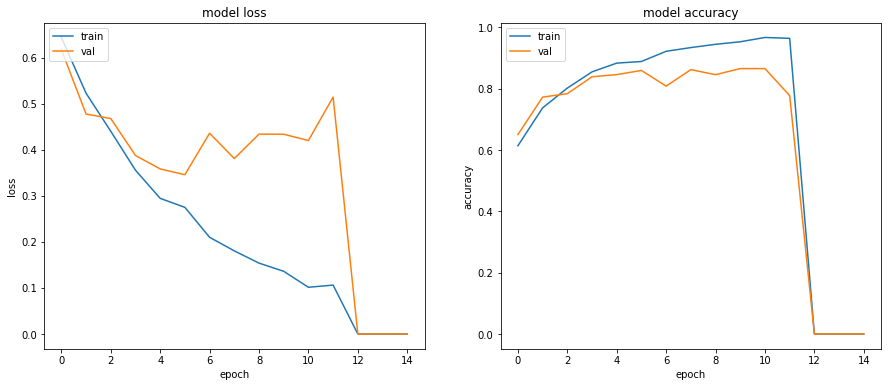

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Creamos también una función para evaluar cualquier dataset (e.g. el test set) con un modelo ya entrenado, y que retorne el loss y accuracy del proceso de inferencia.

In [53]:
def eval_model(modelo, dataloader, loss_fn=nn.BCELoss()):
    modelo.eval()
    loss = 0
    accuracy = 0

    with torch.no_grad():
        for batch_idx, (batch_features, batch_labels, batch_lengths) in enumerate(dataloader):
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            batch_preds = modelo(batch_features, batch_lengths)[:, 0]
            loss += loss_fn(batch_preds, batch_labels).item() * batch_labels.size(0)
            correctos = (batch_preds.gt(0.5).type(torch.float) == batch_labels)
            accuracy += correctos.type(torch.float).sum().item()
            
    # se normalizan el loss y el accuracy del val set
    loss /= len(dataloader.dataset)
    accuracy /= len(dataloader.dataset)
    return loss, accuracy

In [ ]:
test_loss, test_acc = eval_model(modelo, test_dl)
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo, "imdb_sentiment_analysis.pth")

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:777: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,


El loss de test es 0.3355336497068405, y el accuracy de test es de 0.863. 


Los resultados son aceptables, con un 86% de accuracy sobre el test set, pero se podrían mejorar con modelos más complejos o con otro tipo de arquitecturas, como la de transformers.

# 5. Modelo recurrente bidireccional de análisis de sentimiento

Los modelos recurrentes que hemos utilizado hasta ahora consideran la secuencia de tokens de texto buscando patrones en el sentido de lectura ("de izquierda a derecha").
Podemos entonces encontrar patrones que considere relaciones entre palabras y una o varias de las palabras sucesoras.
Existen también patrones entre palabras y una o varias de las palabras antecesoras que los modelos recurrentes de base no consideran. Se consideran entonces implementaciones bidireccionales, capaces de analizar las secuencias en ambos sentidos de la secuencia a la vez (aunque se consideran relaciones entre patrones de sentidos contrarios).

En tratamiento de lenguaje natural esto cobra importancia, por ejemplo al poder otorgarle una semántica diferente a palabras homónimas dependiendo de las palabras que le suceden: "el banco no me quiso cobrar el cheque" vs "el banco estaba muy incómodo y no pude sentarme".

Reutilizaremos el embedding ilustrativo previamente construido (3 dimensiones, 10 tokens), para entender el funcionamiento de una capa BiLSTM con 8 células.
La capa recurrente recibirá un tensor de 2 instancias, cada una con secuencias de 4 tokens, representados en un embedding de 3 dimensiones.

In [ ]:
text_encoded_input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
embedding_output = embedding(text_encoded_input)
print(embedding_output.shape)
print(embedding_output)

torch.Size([2, 4, 3])
tensor([[[-0.4514, -0.5918, -0.0180],
         [ 0.9769,  0.0398,  0.2782],
         [-0.8889, -0.4585,  1.5537],
         [-0.0930,  0.9984,  0.3493]],

        [[-0.8889, -0.4585,  1.5537],
         [ 1.7969,  0.8506, -1.1664],
         [ 0.9769,  0.0398,  0.2782],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)


In [ ]:
lstm_nobi = nn.LSTM(3, 8, batch_first=True, bidirectional=False)
lstm_bi = nn.LSTM(3, 8, batch_first=True, bidirectional=True)

In [ ]:
for name, value in lstm_nobi.named_parameters():
    print(f"{name}: {value.shape}")
print("")
for name, value in lstm_bi.named_parameters():
    print(f"{name}: {value.shape}")

weight_ih_l0: torch.Size([32, 3])
weight_hh_l0: torch.Size([32, 8])
bias_ih_l0: torch.Size([32])
bias_hh_l0: torch.Size([32])

weight_ih_l0: torch.Size([32, 3])
weight_hh_l0: torch.Size([32, 8])
bias_ih_l0: torch.Size([32])
bias_hh_l0: torch.Size([32])
weight_ih_l0_reverse: torch.Size([32, 3])
weight_hh_l0_reverse: torch.Size([32, 8])
bias_ih_l0_reverse: torch.Size([32])
bias_hh_l0_reverse: torch.Size([32])


Vemos que la capa tiene el doble de parámetros que las capas LSTM no bidireccionales, con matrices de pesos y vectores de sesgos separados para cada sentido de procesamiento, con tensores de la misma dimensionalidad.

Procesemos ahora el embedding de las dos frases de 4 tokens codificadas anteriormente:

In [ ]:
preds_nobi = lstm_nobi(embedding_output)
preds_bi = lstm_bi(embedding_output)

El resultado de una capa `LSTM` es una tupla de dos elementos, independientemente de si es bidireccional o no.

In [ ]:
print(f"preds_nobi: {len(preds_nobi)}")
print(f"preds_nobi[0]: {preds_nobi[0].shape}")
print(f"preds_nobi[1]: {len(preds_nobi[1])}")
print(f"preds_nobi[1][0]: {preds_nobi[1][0].shape}")
print(f"preds_nobi[1][1]: {preds_nobi[1][1].shape}")
print("")
print(f"preds_bi: {len(preds_bi)}")
print(f"preds_bi[0]: {preds_bi[0].shape}")
print(f"preds_bi[1]: {len(preds_bi[1])}")
print(f"preds_bi[1][0]: {preds_bi[1][0].shape}")
print(f"preds_bi[1][1]: {preds_bi[1][1].shape}")


preds_nobi: 2
preds_nobi[0]: torch.Size([2, 4, 8])
preds_nobi[1]: 2
preds_nobi[1][0]: torch.Size([1, 2, 8])
preds_nobi[1][1]: torch.Size([1, 2, 8])

preds_bi: 2
preds_bi[0]: torch.Size([2, 4, 16])
preds_bi[1]: 2
preds_bi[1][0]: torch.Size([2, 2, 8])
preds_bi[1][1]: torch.Size([2, 2, 8])


El resultado de la capa es una tupla de 2 elementos:
- un primer elemento tensor organizado así: (batch, secuencia, estados escondidos finales de cada célula), que incluye los estados escondidos para cada elemento de la secuencia. En el caso no bidireccional tenemos en la última dimension las 8 células de la capa; en el caso bidireccional estos estados se duplican, incluyendo los estados de salida en ambos sentido.
- el segundo elemento es una tupla de 2 posiciones:
    - un tensor con solo los últimos estados escondidos de cada instancia (número de capas recurrentes, batch, número de células). En el caso de una capa bidireccional, el primer eje contiene el doble de posiciones, con la concatenación de los últimos estados escondidos en el sentido "de izquierda a derecha", y los primeros estados de "derecha a izquierda".
    - un tensor con el valor de los últimos valores del cell state de cada célula (número de capas recurrentes, batch, número de células). En el caso de una capa bidireccional, el primer eje contiene el doble de posiciones, con la concatenación de los últimos cell states en el sentido "de izquierda a derecha", y los primeros cell states de "derecha a izquierda".

In [ ]:
preds_bi[0]

tensor([[[ 0.0184,  0.1219, -0.0998,  0.1157, -0.1100, -0.0150, -0.0851,
          -0.1640, -0.0626,  0.0749, -0.0988, -0.2047, -0.0042, -0.0112,
           0.1247,  0.2697],
         [-0.0241,  0.1512, -0.2896,  0.0283, -0.0650,  0.0530, -0.0975,
          -0.2972, -0.0610,  0.0716, -0.1457, -0.1857, -0.0106, -0.0406,
           0.0975,  0.2804],
         [ 0.1073,  0.1485, -0.2391, -0.0032, -0.0846,  0.0078, -0.1860,
          -0.3381, -0.0738,  0.1198, -0.0381, -0.1657,  0.0137,  0.0504,
           0.1716,  0.1860],
         [ 0.0970,  0.1470, -0.2351, -0.0340, -0.0437, -0.0018, -0.1785,
          -0.2838, -0.0933,  0.0619, -0.1218,  0.0253,  0.0450, -0.0440,
           0.0772,  0.1012]],

        [[ 0.1008,  0.0560, -0.1194,  0.0152, -0.0544, -0.0252, -0.1490,
          -0.1861, -0.0597,  0.0682, -0.0548, -0.1729,  0.0037, -0.0354,
           0.0960,  0.1931],
         [-0.0459,  0.1261, -0.2922,  0.0080,  0.0031,  0.1172, -0.0877,
          -0.2560, -0.0477, -0.0885, -0.3653, -0.0

In [ ]:
preds_bi[1][0]

tensor([[[ 0.0970,  0.1470, -0.2351, -0.0340, -0.0437, -0.0018, -0.1785,
          -0.2838],
         [-0.0132,  0.1636, -0.2958,  0.0076, -0.0608,  0.0759, -0.1215,
          -0.3417]],

        [[-0.0626,  0.0749, -0.0988, -0.2047, -0.0042, -0.0112,  0.1247,
           0.2697],
         [-0.0597,  0.0682, -0.0548, -0.1729,  0.0037, -0.0354,  0.0960,
           0.1931]]], grad_fn=<StackBackward0>)

Creamos entonces un nuevo modelo con una capa recurrente `LSTM` bidireccional.
Durante el procesamiento en el método `forward`, vamos a concatenar los estados de salida en las dos direcciones como entrada a la primera capa densa; esta capa tiene entonces el doble de entradas que el número de células recurrentes.

In [62]:
class SentimentAnalysisModelBidirectional(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)

        _, (hidden, cell) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

Creamos un modelo bidireccional y lo entrenamos.

In [ ]:
torch.manual_seed(1)
modelo_bi = SentimentAnalysisModelBidirectional(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
modelo_bi = modelo_bi.to(DEVICE)

modelo_bi, train_losses, train_accuracies, val_losses, val_accuracies = \
    train_model_sentiment(modelo_bi, train_dl, val_dl, learning_rate=1e-3, epocas=15, early_stopping_loss_val_patience=5, verbose=True)

0:  loss: 0.626397, accuracy: 0.634520, val loss: 0.562371, val accuracy: 0.708800 -- time: 126.29
Se mejoró el loss de inf a 0.5623705344200134
1:  loss: 0.510674, accuracy: 0.746160, val loss: 0.495297, val accuracy: 0.758000 -- time: 125.57
Se mejoró el loss de 0.5623705344200134 a 0.49529733810424803
2:  loss: 0.411996, accuracy: 0.813680, val loss: 0.510835, val accuracy: 0.769000 -- time: 117.60
3:  loss: 0.405432, accuracy: 0.815280, val loss: 0.425857, val accuracy: 0.797600 -- time: 118.75
Se mejoró el loss de 0.49529733810424803 a 0.42585708951950074
4:  loss: 0.290321, accuracy: 0.882080, val loss: 0.351341, val accuracy: 0.847200 -- time: 118.67
Se mejoró el loss de 0.42585708951950074 a 0.3513411153793335
5:  loss: 0.228594, accuracy: 0.910520, val loss: 0.345966, val accuracy: 0.857200 -- time: 119.07
Se mejoró el loss de 0.3513411153793335 a 0.3459660375118256
6:  loss: 0.186487, accuracy: 0.930280, val loss: 0.343455, val accuracy: 0.867200 -- time: 118.88
Se mejoró el 

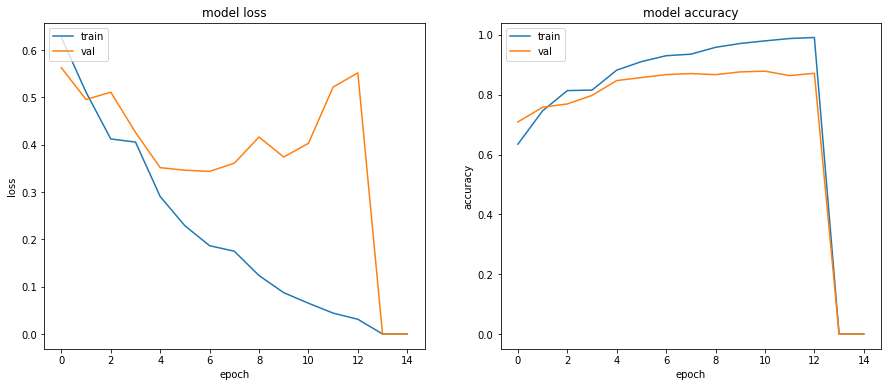

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
test_loss, test_acc = eval_model(modelo_bi, test_dl)
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo, "imdb_sentiment_analysis_bi.pth")

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:777: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,


El loss de test es 0.32635941242575645, y el accuracy de test es de 0.876. 


Con el modelo no bidireccional, el loss de test era de 0.336 y el accuracy de 86.3%. Con el modelo bidireccional mejoramos la calidad de las predicciones solo un poco, reduciendo el loss a 0.326 y aumentando el accuracy a 87.6%.

# 6. Transfer learning sobre embeddings

De la misma manera que se puede aprovechar la extracción de features de imágenes a partir de modelos convolucionales, se puede reutilizar embeddings previamente entrenados para realizar tareas de NLP similares sobre conjuntos de textos de mucha mayor extensión.

Vamos entonces a reutilizar un embedding llamado **GloVe**, acrónimo de "Global Vectors for Word Representation", un proyecto de Stanford (https://nlp.stanford.edu/projects/glove/) que, a partir de un algoritmo de aprendizaje no supervisado aplicado a un corpus de estadísticas sobre co-ocurrencias entre palabras permite obtener embeddings que abstraen relaciones lineales en el nuevo espacio de representación entre diferentes palabras.

Vamos a descargar y descomprimir el archivo de embeddings

In [54]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-02-22 19:16:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-22 19:16:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-22 19:16:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [55]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


GloVe incluye varios embeddings, con espacios vectoriales de diferente número de dimensiones (50, 100, 200, 300). Veamos la estructura de las primeras líneas del archivo correspondiente al embedding de 30 dimensiones.

In [56]:
myfile = open("glove.6B.50d.txt", "r")
i = 0
while myfile:
    line  = myfile.readline()
    print(line)
    if line == "" or i==5:
        break
    i = i+1
myfile.close() 

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581

, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392

. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.423

Vemos que cada línea incluye la representación de una palabra (se incluyen los signos de puntuación) en vectores de 50 dimensiones.

Vamos a cargar y recorrer el archivo en una lista (a cada línea le quitamos el salto de línea). Cada línea se separa por espacios; la primera posición se extrae como la palabra (se agrega a un diccionario ordenado), y el resto como el vector de representación correspondiente (que se agrega a una lista).

In [57]:
embeddings = []
vocab_globe_dict = OrderedDict({})
with open('glove.6B.50d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab_globe_dict[i_word]=1
    embeddings.append(i_embeddings)

Modificamos el diccionario y los embeddings.

In [58]:
embedding_array = np.array(embeddings)

In [59]:
len(vocab_globe_dict)

400000

In [60]:
embedding_array.shape

(400000, 50)

Vemos que el embedding incluye la representación de 400000 tokens en un espacio vectorial de 50 dimensiones. Agregamos los tokens especiales de \<unk\> y de \<pad\>.

In [61]:
pad_emb = np.zeros((1, embedding_array.shape[1]))   #embedding for '<pad>' token.
unk_emb = np.mean(embedding_array, axis=0, keepdims=True)    #embedding for '<unk>' token.
print(pad_emb)
print(unk_emb)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
[[-0.12920061 -0.28866239 -0.01224894 -0.05676689 -0.20211109 -0.08389026
   0.33359737  0.16045146  0.03867495  0.17833092  0.0469662  -0.00285779
   0.29099851  0.04613723 -0.20923842 -0.066131   -0.06822448  0.07665885
   0.31339918  0.17848512 -0.12257719 -0.09916928 -0.07495973  0.06413206
   0.14441256  0.608946    0.17463101  0.05335403 -0.01273826  0.03474108
  -0.81239567 -0.04688727  0.20193533  0.20311115 -0.03935654  0.06967518
  -0.01553655 -0.03405275 -0.06528025  0.12250092  0.13992005 -0.17446305
  -0.08011841  0.08495219 -0.01041645 -0.13704901  0.20127088  0.10069294
   0.00653007  0.0168515 ]]


In [62]:
embedding_array = np.vstack((pad_emb, unk_emb, embedding_array))
print(embedding_array.shape)

(400002, 50)


Creamos ahora una capa `Embedding` con la matriz de representación de Glove

In [63]:
embedding_glove = nn.Embedding.from_pretrained(torch.from_numpy(embedding_array).float())
embedding_glove

Embedding(400002, 50)

In [88]:
embedding_array[2]

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

In [89]:
embedding_glove.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1292, -0.2887, -0.0122,  ...,  0.1007,  0.0065,  0.0169],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        ...,
        [-0.5118,  0.0587,  1.0913,  ..., -0.2500, -1.1250,  1.5863],
        [-0.7590, -0.4743,  0.4737,  ...,  0.7895, -0.0141,  0.6448],
        [ 0.0726, -0.5139,  0.4728,  ..., -0.1891, -0.5902,  0.5556]],
       device='cuda:0')

Es importante ahora hacer una pausa y remarcar que los tokens considerados en este vocabulario son diferentes a los que previamente tratamos: no hay consideración de emoticones, se incluyen los signos de puntuación, y el número de tokens supera con creces el número de tokens del vocabulario original, por lo que los tokens considerados como desconocidos si podrán tener una semántica definida usando **GloVe**.

Necesitaremos entonces volver a recrear el proceso de tokenización de las reviews de IMDb para poder utilizarlo conjuntamente con el `Embedding` de Glove.
Esta vez no lo vamos a crear desde cero, sino que vamos a utilizar algunas de las funcionalidades del package `torchtext`.

Utilizaremos, por ejemplo, el método `get_tokenizer` permite obtener tokenizadores predefinidos. Recibe el nombre del tokenizer (e.g. `'basic_english'`) y el lenguaje (por defecto inglés - `'EN'`). Se le puede pasar una función externa que se encargue de la tokenización; existen varias librerias de tokenización que se pueden utilizar como `spacy`, `moses`, `toktok`, `revtok`, `subword`.

In [64]:
import torchtext
from torchtext.data import get_tokenizer

In [65]:
tokenizer = get_tokenizer('basic_english')

In [66]:
tokens = tokenizer("I don't want to go to the office!")
tokens

['i', 'don', "'", 't', 'want', 'to', 'go', 'to', 'the', 'office', '!']

Creamos una instancia de `Vocab` a partir del diccionario que contiene los tokens de **GloVe**.

In [67]:
from torchtext import vocab

In [68]:
vocab_glove = vocab.vocab(vocab_globe_dict)
vocab_glove.insert_token("<pad>", 0)
vocab_glove.insert_token("<unk>", 1)
vocab_glove.set_default_index(1)

In [69]:
len(vocab_glove)

400002

In [70]:
print(f"<pad>: {vocab_glove['<pad>']}")
print(f"<unk>: {vocab_glove['<unk>']}")
print(f"the: {vocab_glove['the']}")
print(f"of: {vocab_glove['of']}")
print(f"and: {vocab_glove['and']}")
print(f"you: {vocab_glove['you']}")
print(f"adfasdfasf: {vocab_glove['adfasdfasf']}")

<pad>: 0
<unk>: 1
the: 2
of: 5
and: 7
you: 83
adfasdfasf: 1


Redefinimos los pipelines para crear los `DataLoaders` que vamos a utilizar

In [71]:
text_pipeline = lambda x: [vocab_glove[token] for token in tokenizer(x)]

In [72]:
text_pipeline("It was great to see some of my favorite stars of 30 years ago")

[22, 17, 355, 6, 255, 79, 5, 194, 2708, 1571, 5, 409, 84, 365]

In [73]:
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)

In [74]:
(text_batch, label_batch, length_batch) = next(iter(dataloader))

In [75]:
print("Estructura de un batch")
print(f"  Secuencias de tokens ({text_batch.shape}): {text_batch}")
print(f"  Etiquetas ({label_batch.shape}): {label_batch}")
print(f"  Largos originales ({length_batch.shape}): {length_batch}")

Estructura de un batch
  Secuencias de tokens (torch.Size([4, 666])): tensor([[ 3708,    16,   245,  ...,     0,     0,     0],
        [14399,     3,   189,  ...,     0,     0,     0],
        [   59,     1,     4,  ...,  1167,  1005,     4],
        [ 2701,   281, 54892,  ...,     0,     0,     0]], device='cuda:0')
  Etiquetas (torch.Size([4])): tensor([0., 0., 1., 0.], device='cuda:0')
  Largos originales (torch.Size([4])): tensor([408, 208, 666, 180], device='cuda:0')


In [76]:
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Creamos un modelo bidireccional y lo entrenamos.

In [77]:
class SentimentAnalysisModelBidirectional_GloVe(nn.Module):
    def __init__(self, vocab_size, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        embed_dim = 50
        self.embedding = embedding_glove
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)

        _, (hidden, cell) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [79]:
torch.manual_seed(1)
modelo_bi_glove = SentimentAnalysisModelBidirectional_GloVe(vocab_size, rnn_hidden_size, fc_hidden_size) 
modelo_bi_glove = modelo_bi_glove.to(DEVICE)

In [80]:
modelo_bi_glove.embedding

Embedding(400002, 50)

In [81]:
modelo_bi_glove, train_losses, train_accuracies, val_losses, val_accuracies = \
    train_model_sentiment(modelo_bi_glove, train_dl, val_dl, learning_rate=1e-3, epocas=15, early_stopping_loss_val_patience=5, verbose=True)

0:  loss: 0.600690, accuracy: 0.667720, val loss: 0.533047, val accuracy: 0.746600 -- time: 107.57
Se mejoró el loss de inf a 0.5330473747253418
1:  loss: 0.472423, accuracy: 0.777160, val loss: 0.417725, val accuracy: 0.810000 -- time: 106.40
Se mejoró el loss de 0.5330473747253418 a 0.41772486009597776
2:  loss: 0.371728, accuracy: 0.831600, val loss: 0.380391, val accuracy: 0.828000 -- time: 106.84
Se mejoró el loss de 0.41772486009597776 a 0.3803913964748383
3:  loss: 0.340526, accuracy: 0.851680, val loss: 0.334386, val accuracy: 0.851200 -- time: 106.36
Se mejoró el loss de 0.3803913964748383 a 0.3343859308242798
4:  loss: 0.314430, accuracy: 0.866360, val loss: 0.331550, val accuracy: 0.852800 -- time: 105.53
Se mejoró el loss de 0.3343859308242798 a 0.33155013890266416
5:  loss: 0.292023, accuracy: 0.876160, val loss: 0.316566, val accuracy: 0.861400 -- time: 105.43
Se mejoró el loss de 0.33155013890266416 a 0.3165660458087921
6:  loss: 0.272394, accuracy: 0.884280, val loss: 0

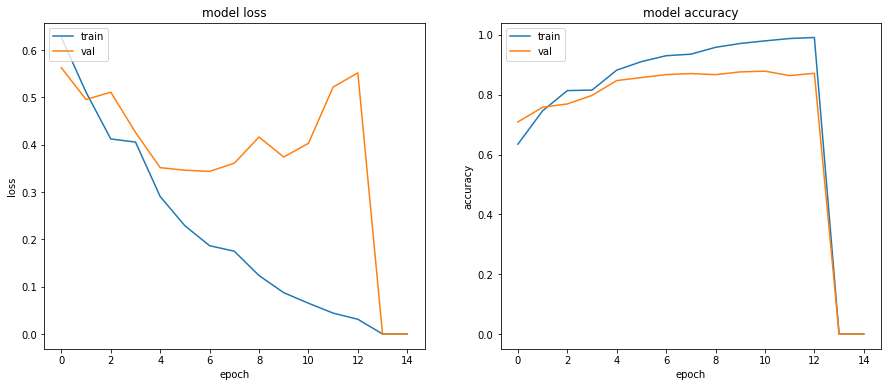

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [83]:
test_loss, test_acc = eval_model(modelo_bi_glove, test_dl)
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo, "imdb_sentiment_analysis_bi_glove.pth")

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:777: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,


El loss de test es 0.2902194746494293, y el accuracy de test es de 0.881. 


Con el modelo no bidireccional, el loss de test era de 0.336 y el accuracy de 86.3%.

Con el modelo bidireccional mejoramos la calidad de las predicciones solo un poco, reduciendo el loss a 0.326 y aumentando el accuracy a 87.6%.

Con el modelo bidireccional con embeddings pre entrenados mejoramos la calidad 
reducimos el loss a 0.29 y aumentando el accuracy a 88.1%.